# Modelo Rosenzweig-MacArthur

Un modelo razonable para las poblaciones de presas y depredadores a través del tiempo, considerando su interacción, podría tener esta forma:

$\dot{x}=$ tasa de nacimiento - tasa de muertes no debidas a $ y $ - tasa de muertes por depredación

$\dot{y}=$ tasa de reproducción - tasa de mortalidad

Donde $ x $ representa la densidad de presas (número de presas por unidad de área), y $ y $ la densidad de depredadores (número de depredadores por unidad de área).

Un modelo cualquiera es una elección de cómo computar estas tasas, así lo abstrae el modelo de **Rosenzweig-McArthur**:

$$\dot{x}=f(x)-\phi(x,y)$$

$$\dot{y}=-ey+k\phi(x,y)$$

Donde $f(x)$ es la tasa de cambio de $x$ cuando no hay depredación, $\phi(x, y)$ es la tasa de depredación, $ k $ la eficiencia con la que los depredadores asimilan a las presas y 
$ e $ la tasa de muertes del depredador ($ e, k>0 $).

In [1]:
# Para hacer experimentos numéricos importamos numpy
import numpy as np

# y biblioteca para plotear
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# cómputo simbólico con sympy
from sympy import *
init_printing()

# definimos qué variables usar como símbolos
x, y, e, phi, f, k, r, K = symbols('x y e phi f k r K')

## Tasa de cambio de la población de presas

La tasa de cambio de $ x $ (nacimientos y muertes de presas) podría modelarse como crecimiento Maltusiano $f(x)=\frac{dx}{dt}=rx\left(1-\frac{x}{K}\right)$, donde la tasa de reproducción es proporcional tanto al tamaño de la población actual como a la cantidad de recursos disponible ($ r,K>0 $). 

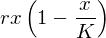

In [2]:
malthusian = r*x*(1-x/K)
malthusian

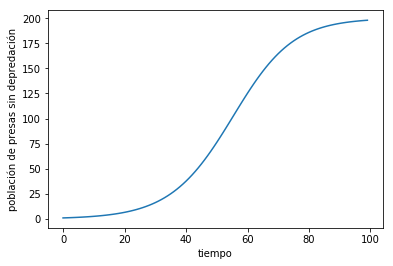

In [3]:
F = lambdify((x, r, K), malthusian)
pop = np.zeros(100)

# población inicial
pop[0] = 1
reproduccion = 0.1
capacidad = 200

# sumamos población en cada t
for t in range(99):
    pop[t+1] = pop[t] + F(pop[t], 
                          reproduccion,
                          capacidad)
    
plt.xlabel("tiempo")
plt.ylabel("población de presas sin depredación")
fig = plt.plot(pop)

## Tasa de cambio de la población de depredadores
Si se asume que la tasa de muertes del depredador es lineal y su densidad no es tal que se interfieran entre sí para cazar, entonces sólo la cantidad de presas limita la población de depredadores. 

$$\dot{x}=f(x)-y\phi(x)$$

$$\dot{y}=-ey+ky\phi(x)$$

$\phi(x)$ es la cantidad de presas atrapadas por depredador por unidad de tiempo, en función de la densidad de presas.

### Tasa de depredación según Holling

Lo esencial es que la tasa de depredación esté en función sólo de la densidad de presas. [Este artículo](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf) discute la creación de tal función considerando el promedio de presas atrapadas a lo largo de un lapso extendido. El argumento $a$ modela el tiempo que le toma al depredador encontrar una presa, mientras que $b$ modela cuánto tiempo le toma atraparla, comérsela, digerirla, dormir la siesta, y empezar a acechar nuevamente.

$$\phi(x)=\frac{ax}{1+bx}$$

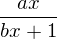

In [4]:
a, b = symbols('a b')
phi_holling = a*x / (1 + b*x)
phi_holling

In [5]:
# convertimos los símbolos de phi_holling en función ejecutable
phi_holling = lambdify((x, a, b), phi_holling)

Con un tiempo para encontrar presa de 20 unidades y un tiempo para consumirlas de 9 encontramos una curva parecida a la del [artículo de Hal L Smith](https://math.la.asu.edu/~halsmith/Rosenzweig.pdf).

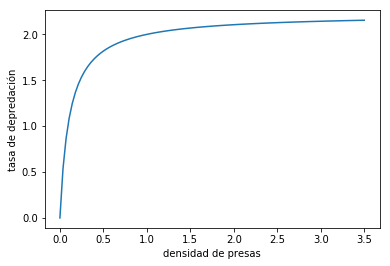

In [6]:
t_encontrar = 20
t_consumir = 9

presas = np.linspace(0, 3.5, 100)

# computamos depredaciones para un rango de densidades de presas
depredaciones = [phi_holling(n, 
                             t_encontrar,
                             t_consumir) 
                 for n in presas]

plt.xlabel("densidad de presas")
plt.ylabel("tasa de depredación")
fig = plt.plot(presas, depredaciones)

## Interacción de ambas poblaciones
Si se asume que la tasa de muertes del depredador es lineal y su densidad no es tal que se interfieran entre sí para cazar, entonces sólo la cantidad de presas limita la población de depredadores. 

$$\dot{x}=x\left(1-\frac{x}{k}\right)-\frac{mxy}{1+x}$$

$$\dot{y}=-ey+\frac{mxy}{1+x}$$


$\phi(x)$ es la cantidad de presas atrapadas por depredador por unidad de tiempo, en función de la densidad de presas.

In [7]:
def presas(m, k):
    def f(x, y):
        return x*(1-x/k)-((m*x*y)/(1+x))
    return f

def depredadores(e, m):
    def g(x, y):
        return (-e*y)+((m*x*y)/(1+x))
    return g

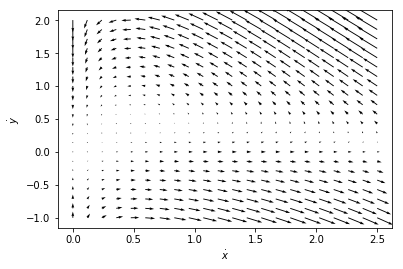

In [55]:
m = 3
k = 3
e = 1
f = presas(m, k)
g = depredadores(e, m)

x, y = np.meshgrid(np.linspace(0, 2.5, 22),
                   np.linspace(-1, 2, 22))

u = f(x, y)
v = g(x, y)
plt.quiver(x, y, u, v)
plt.xlabel("$\dot{x}$")
plt.ylabel("$\dot{y}$")
plt.show()

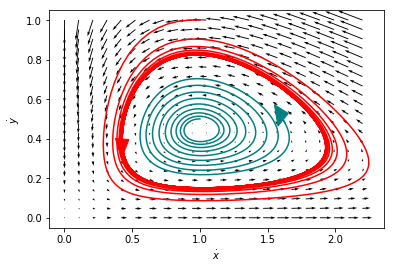

In [66]:
m = 3
k = 3
e = 1.5
f = presas(m, k)
g = depredadores(e, m)

x, y = np.meshgrid(np.linspace(0, 2.2, 22),
                   np.linspace(0, 1, 22))

u = f(x, y)
v = g(x, y)
plt.quiver(x, y, u, v)

def step(x, y, dt, f, g):
    """
    Devuelve una nueva coordenada a partir de:
     - la actual (x, y)
     - delta t
     - funciones de tasa de cambio
    """
    return (x + dt * f(x, y),
            y + dt * g(x, y))

def trayectoria(x0, y0, f, g, dt=0.01, steps=100):
    """
    Calcula una trayectoria dado un punto inicial, las funciones
    de tasa de cambio, delta t y un número de iteraciones.
    """
    x = x0
    y = y0
    t = list()
    for n in range(steps):
        t.append((x, y))
        x, y = step(x, y, dt, f, g)
    return t

x0 = 1
y0 = 0.5
dt = 0.1
steps = 800
xp, yp = zip(*[coord
           for coord in
           trayectoria(x0, y0, f, g, dt, steps)])
plt.plot(xp, yp, color='teal')
plt.arrow(xp[-2], yp[-2],
          xp[-1] - xp[-2], yp[-1] - yp[-2],
          color="teal", head_width=0.1, head_length=0.1)

x0 = 1
y0 = 1
dt = 0.1
steps = 1400
xd, yd = zip(*[coord
           for coord in
           trayectoria(x0, y0, f, g, dt, steps)])
plt.plot(xd, yd, color='red')
plt.arrow(xd[-2], yd[-2],
          xd[-1] - xd[-2], yd[-1] - yd[-2],
          color="red", head_width=0.1, head_length=0.1)

plt.xlabel("$\dot{x}$")
plt.ylabel("$\dot{y}$")

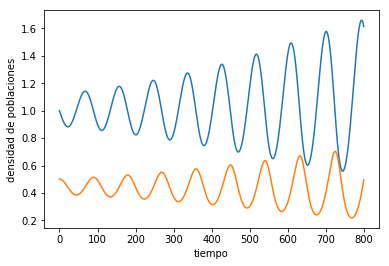

In [63]:
steps = 800

t = np.arange(800)

plt.xlabel("tiempo")
plt.ylabel("densidad de poblaciones")
fig = plt.plot(t, xp)
fig = plt.plot(t, yp)

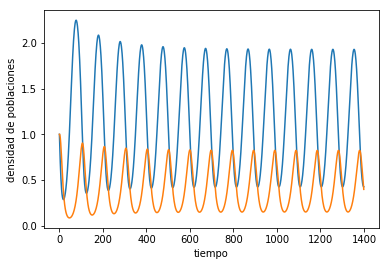

In [68]:
steps = 800

t = np.arange(1400)

plt.xlabel("tiempo")
plt.ylabel("densidad de poblaciones")
fig = plt.plot(t, xd)
fig = plt.plot(t, yd)